# SIMN - Ka band correlation study

In [1]:
# Libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ismn.interface import ISMN_Interface
from scipy import stats
# Custom
import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global
%matplotlib inline

ka_path = "../data/raw/ka.zip"
ismn_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"

In [2]:
# Load Ka zip and save the Brightness temperature
ka_dataset = load_zip(ka_path)
ka_dataset = apply_scaling(ka_dataset)

Loading zipfile from ../data/raw/ka.zip


100%|██████████| 754/754 [00:18<00:00, 41.85it/s]


Applying scaling


100%|██████████| 3/3 [00:12<00:00,  4.25s/it]


In [3]:
# Load the ISMN data and select for the station,
ismn_data = ISMN_Interface(ismn_path)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [4]:
# Selection
network = "FMI"
station = "SOD130"
sensor = "CS655-B_soil_temperature_0.050000_0.050000"

In [5]:
# Get lat and lon coordinates
lon = ismn_data[network][station][sensor].metadata["longitude"][1]
lat = ismn_data[network][station][sensor].metadata["latitude"][1]

Text(0.5, 1.0, 'Network: FMI, station: SOD130')

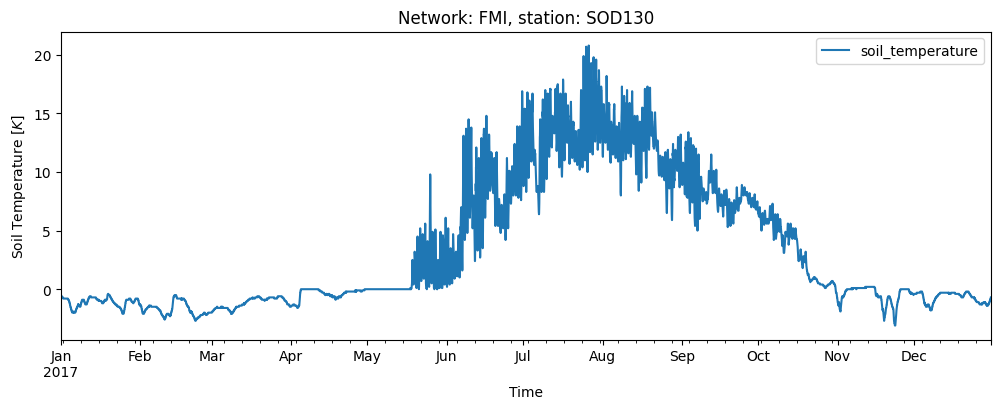

In [10]:
# Get the timeseries for the sensor
ismn_timeseries = ismn_data[network][station][sensor]

# Optional: plot
ax = ismn_timeseries.data.plot(figsize=(12, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Soil Temperature [$°C$]")
plt.title(f"Network: {network}, station: {station}")

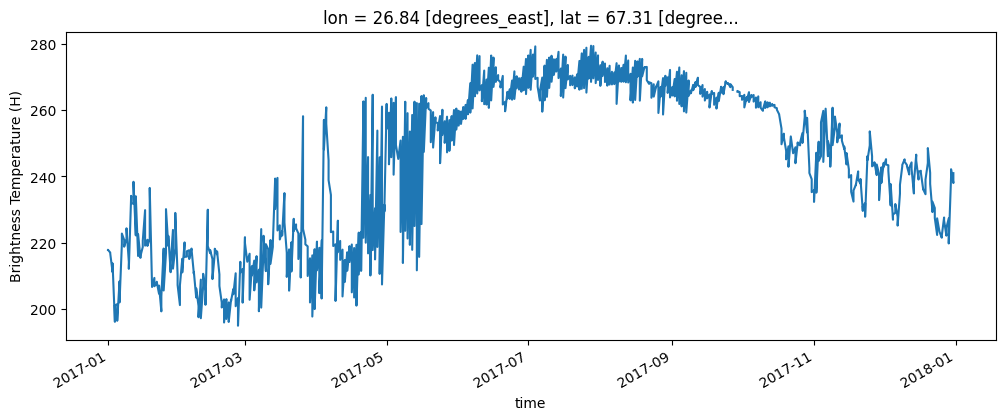

In [6]:
# Select the ka band for the coordinates
ka_timeseries = ka_dataset.sel({"lat": lat, "lon": lon}, method="nearest")
ka_timeseries["Brightness Temperature (H)"].plot(figsize=(12, 4))

In [7]:
ka_timeseries

<xarray.Dataset>
Dimensions:                     (time: 730)
Coordinates:
    lon                         float32 26.84
    lat                         float32 67.31
  * time                        (time) datetime64[ns] 2017-01-01 ... 2017-12-31
    Pass                        (time) <U10 'Ascending' ... 'Descending'
Data variables:
    Brightness Temperature (H)  (time) float32 217.8 217.8 217.0 ... 238.0 241.0
    Brightness Temperature (V)  (time) float32 230.8 230.6 229.6 ... 247.6 249.3
    Time Information            (time) float32 -145.0 -538.0 ... -601.0 68.0
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [112]:
# Rolling average is just a kind of convolution
# ismn_rollingts = np.convolve(ismn_timeseries.data['soil_temperature'], v = [1/24 for i in range(24)], mode= "full")
# plt.figure(figsize=(12,4))
# plt.plot(ismn_rollingts)
# plt.show()
# print(ismn_rollingts.shape)

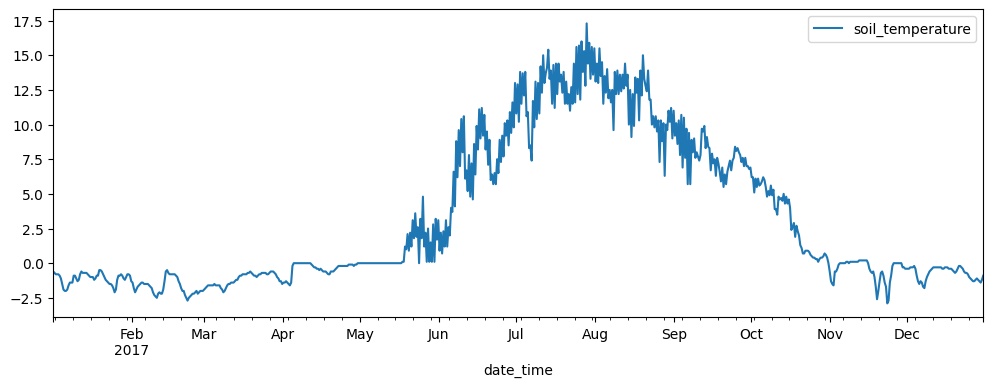

(728, 3)


In [11]:
# We really only need the 6pm and 18pm reading
ismn_passing = ismn_timeseries.data[
    (ismn_timeseries.data.index.hour == 6) | (ismn_timeseries.data.index.hour == 18)
]
ismn_passing.plot(figsize=(12, 4))
plt.show()
print(ismn_passing.shape)

---
Since all observations are at most, daily, lets add a rolling window of 24h to each of the timeseries before we compare them


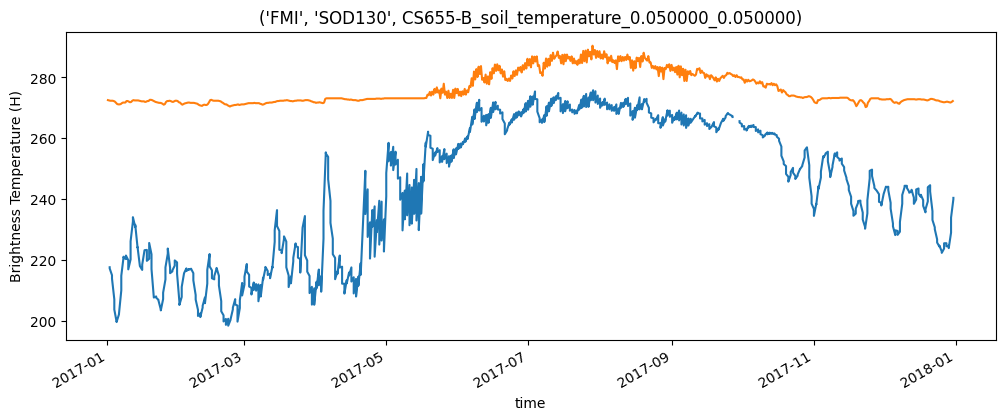

In [12]:
ka_rollingts = ka_timeseries["Brightness Temperature (H)"].rolling(time=3).mean()
ka_rollingts.plot(figsize=(12, 4))
plt.plot(ismn_passing["soil_temperature"] + 273.15)  # We need to convert °C into K
message = (
    ismn_timeseries.metadata["network"][1],
    ismn_timeseries.metadata["station"][1],
    ismn_timeseries,
)
plt.title(message)
plt.show()

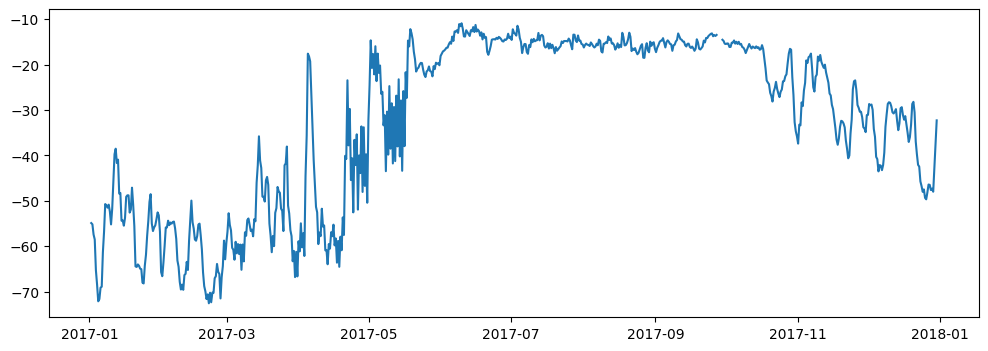

In [13]:
# Difference between values
plt.figure(figsize=(12, 4))
plt.plot(ka_rollingts.values[1:-1] - (ismn_passing["soil_temperature"] + 273.15))

In [17]:
# Let's calculate Holme's LST from the ka data and compare the two signals


def holmes(timeseries: np.array):
    a = 1.11
    b = -15.3
    return timeseries * a + b


#
ka_timeseries["holmes_LST"] = holmes(ka_timeseries["Brightness Temperature (H)"])

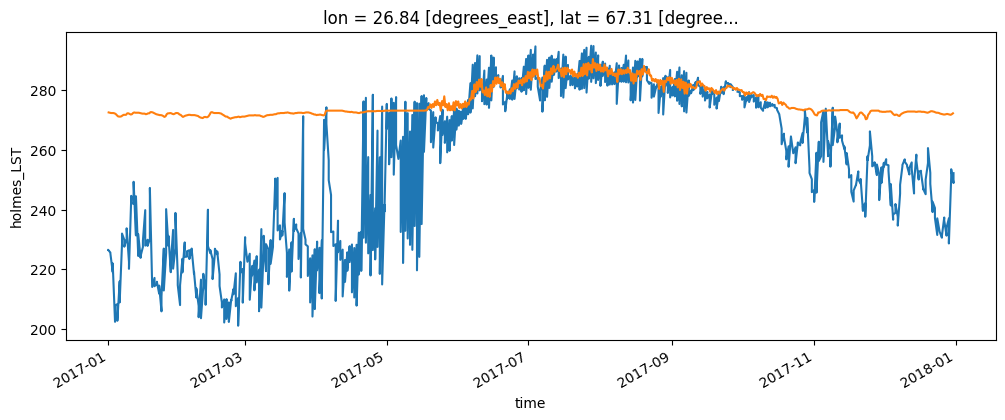

In [22]:
plt.figure(figsize=(12, 4))
ka_timeseries["holmes_LST"].plot()
plt.plot(ismn_passing["soil_temperature"] + 273.15)

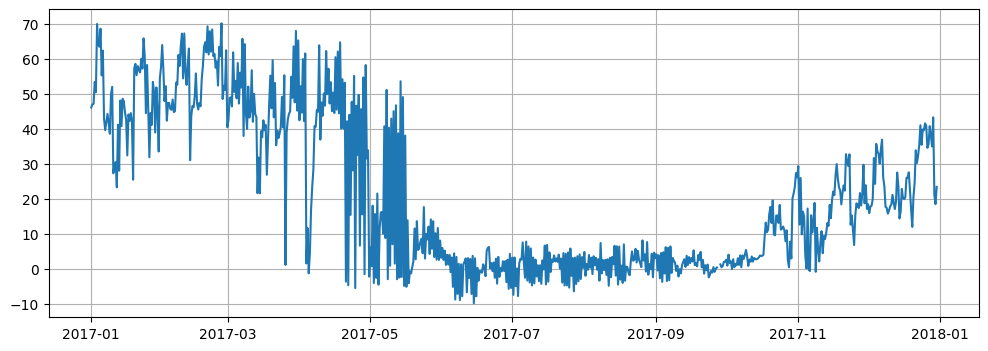

In [26]:
# Difference
plt.figure(figsize=(12, 4))

plt.plot(
    (ismn_passing["soil_temperature"] + 273.15) - ka_timeseries["holmes_LST"][1:-1]
)
plt.grid()

In [54]:
# Lets now separate ascending and descending passes in the ka band, which correspond with 6am - 6mp readings at the station

ka_ascending_ts = ka_timeseries.where(ka_timeseries.Pass == "Ascending", drop=True)
ka_descending_ts = ka_timeseries.where(ka_timeseries.Pass == "Descending", drop=True)

In [61]:
ka_ascending_ts["holmes_LST"] = holmes(ka_ascending_ts["Brightness Temperature (H)"])
ka_descending_ts["holmes_LST"] = holmes(ka_descending_ts["Brightness Temperature (H)"])

In [62]:
ismn_timeseries = ismn_data[network][station][sensor]
ismn_6am = ismn_timeseries.data[(ismn_timeseries.data.index.hour == 6)]

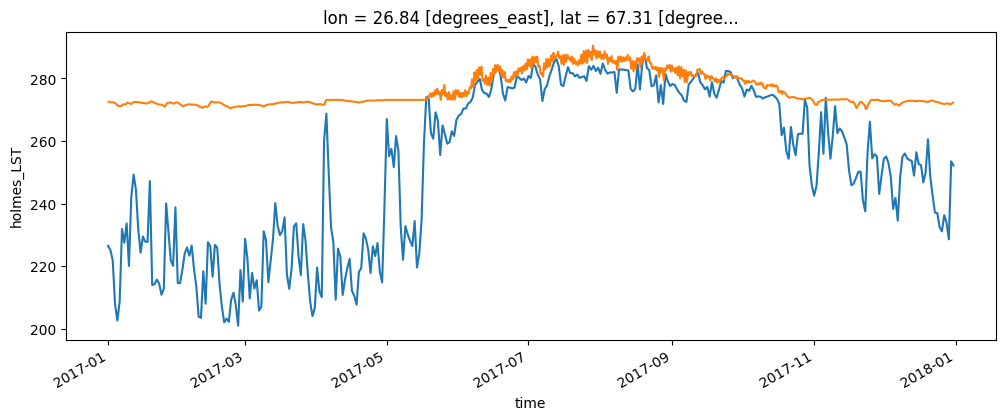

In [66]:
plt.figure(figsize=(12, 4))
ka_descending_ts["holmes_LST"].plot()
plt.plot(ismn_passing["soil_temperature"] + 273.15)